# Статистический анализ данных сервиса аренды самокатов GoFast

Мы имеем данные о некоторых пользователях сервиса аренды самокатов GoFast из нескольких городов, а также об их поездках. Чтобы воспользоваться самокатом, пользователь должен установить приложение, и выбрать один из вариантов проката:
* без подписки, но тогда за старт поездки нужно заплатить 50 руб и стоимость минуты составляет 8 руб.
* с подпиской, начало любой подписки бесплатно, стоимость минуты 6 руб, но ежемесячная плата составляет 199 руб.

У нас есть следующие данные:
- данные о пользователях
    
    это `user_id` каждого пользователя, его имя, возраст, в каком городе находится пользователь и вариант проката (с подпиской или без)
- данные о поездках
    
    здесь мы имеем `user_id` пользователя, какое расстояние он проехал, сколько времени было потрачено на поездку и дата поездки
- данные о варианте проката
    
    стоимость минуты, стоимость начала поездки и ежемесячная плата
    
**Наша цель:** изучить полученные данные, получить представление о том, кто является пользователями сервиса, какую выручку получает сервис от разного типа пользователей (с подпиской и без)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from math import sqrt, factorial
from scipy.stats import binom, norm

## Загрузка данных

Загрузим данные в три датасета.

In [6]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', sep=',')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Мы имеем данные о 1565 пользователях. О пользователях нам известно его `user_id` в системе, имя пользователя, возраст, город, в котором находится пользователь и тип подписки.

In [9]:
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', parse_dates=['date'])
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Нам предоставили данные о 18068 поездках, которые совершили наши пользователи. Мы знаем `user_id` пользователя, совершившего поездку, расстояние, которое проехал пользователь, время, которое было затрачено на поездку и дата поездки.

In [12]:
subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [13]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Данные о варианте использования сервиса содержат лишь две строки, что подтвеждает вводную информацию, что можно использовать сервис только с подпиской или без. Мы получили данные о типе подписки, стоимости минуты, стоимости начала поезки и ежемесяной платы для каждого варианта пользования сервисом.

## Предобработка данных

В данных о поездкам мы видели, что столбец `date` имеет тип object, приведем его к типу даты date.

In [17]:
# rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
# rides.info()

Найдем за какой период нам предоставлены данные.

In [19]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [20]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Нам предоставлены данные о поездках, совершенным в период с 1 января по 30 декабря 2021 года.

Создадим новый столбец `month`, в котором мы укажем месяц, когда была совершена поездка.

In [23]:
rides['month'] = rides['date'].dt.to_period('M')
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,2021-01
1,1,2617.592153,15.816871,2021-01-18,2021-01
2,1,754.159807,6.232113,2021-04-20,2021-04
3,1,2694.783254,18.511000,2021-08-11,2021-08
4,1,4028.687306,26.265803,2021-08-28,2021-08


Также создадим столбец `speed`, в котором будет указана  средняя скорость, которую развивал самокат в ходе поездки. Скорость будем указывать в километрах в час.

In [25]:
rides['speed']=rides['distance']*60/(rides['duration']*1000)
rides.head(5)

,user_id,distance,duration,date,month,speed
0,1,4409.919140,25.599769,2021-01-01,2021-01,10.335841
1,1,2617.592153,15.816871,2021-01-18,2021-01,9.929620
2,1,754.159807,6.232113,2021-04-20,2021-04,7.260713
3,1,2694.783254,18.511000,2021-08-11,2021-08,8.734644
4,1,4028.687306,26.265803,2021-08-28,2021-08,9.202888


Посмотрим, как распределены скорости.

In [27]:
rides['speed'].describe()

count    18068.000000
mean        13.785261
std         44.156189
min          0.005133
25%          8.127843
50%         10.251135
75%         12.929800
max        865.320929
Name: speed, dtype: float64

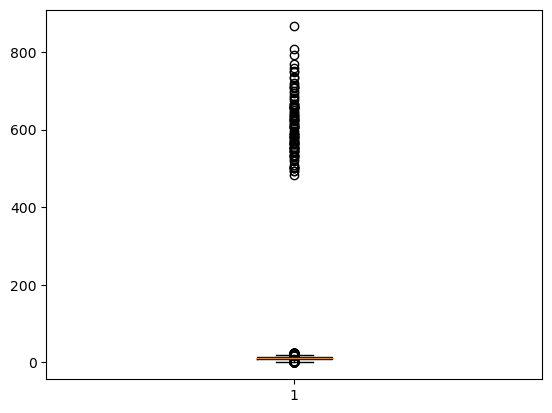

In [28]:
plt.boxplot(rides['speed'])
plt.show();

Проверим поездки с аномально низкой скоростью

In [30]:
rides[rides['speed']<1]

,user_id,distance,duration,date,month,speed
6611,707,28.793204,14.143966,2021-09-12,2021-09,0.122143
6691,712,23.963062,2.053251,2021-11-22,2021-11,0.700247
6699,713,195.694445,12.559127,2021-08-02,2021-08,0.934911
6794,720,193.383776,12.773535,2021-03-01,2021-03,0.908365
6816,721,62.568138,7.178766,2021-09-25,2021-09,0.522943
...,...,...,...,...,...,...
17760,1514,75.573191,5.174400,2021-01-26,2021-01,0.876313
17808,1517,180.812768,11.493126,2021-01-10,2021-01,0.943935
17856,1521,106.417577,9.304050,2021-04-04,2021-04,0.686266
17881,1522,217.943366,14.435887,2021-09-18,2021-09,0.905840


мы видим, что есть 117 поездок с очень низкой скоростью передвижения, скорее всего, пользователь не сразу смог разобраться в управлении, но прокат приносит прибыль за время проката, поэтому такие поездки оставим в наших данных.

Как правило скорость арендных самокатов ограничивают 25 км/ч, посмотрим есть ли у нас поезки, во время которых скорость превышала это значение.

In [33]:
rides[rides['speed'] > 400]

,user_id,distance,duration,date,month,speed
6531,701,4196.445201,0.5,2021-08-31,2021-08,503.573424
6570,704,4830.824371,0.5,2021-10-14,2021-10,579.698925
6680,712,4684.004397,0.5,2021-03-04,2021-03,562.080528
6695,713,5215.642710,0.5,2021-02-25,2021-02,625.877125
6768,718,5197.436649,0.5,2021-02-11,2021-02,623.692398
...,...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,2021-01,663.760301
17242,1477,6724.932981,0.5,2021-01-12,2021-01,806.991958
17314,1483,4445.481070,0.5,2021-03-06,2021-03,533.457728
17505,1496,5722.551787,0.5,2021-02-14,2021-02,686.706214


Как видим, у нас есть 95 поездок, где скорость аномально высокая и все они длились не больше минуты, но при этом указывается очень большое расстояние. Видимо, здесь произошел сбой.

Посмотрим, есть у нас пропуски и дубликаты в данных.

In [36]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

В данных о пользователях пропусков нет, проверим дубликаты

In [38]:
users.duplicated().sum()

31

У нас есть дубликаты 31 строки. Уточним,полученные результаты

In [40]:
users.value_counts()

user_id  name       age  city            subscription_type
209      Андрей     23   Омск            ultra                2
807      Александр  28   Екатеринбург    free                 2
611      Владимир   28   Омск            ultra                2
43       Стефания   22   Омск            ultra                2
737      Мелания    27   Ростов-на-Дону  free                 2
                                                             ..
520      Анжелика   30   Екатеринбург    ultra                1
519      Даниэль    22   Ростов-на-Дону  ultra                1
518      Алиса      22   Ростов-на-Дону  ultra                1
517      Олег       25   Краснодар       ultra                1
1534     Альберт    25   Краснодар       free                 1
Name: count, Length: 1534, dtype: int64

In [41]:
users.query('user_id == 209')

,user_id,name,age,city,subscription_type
208,209,Андрей,23,Омск,ultra
1559,209,Андрей,23,Омск,ultra


Как видим, в данных о пользователях есть дубликаты, удалим их.

In [43]:
users.drop_duplicates()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


Посмотрим есть ли в данных о поездках пропуски или дубликаты.

In [45]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
speed       0
dtype: int64

In [46]:
rides.duplicated().sum()

0

In [47]:
rides[['user_id','distance','duration','date']].value_counts()

user_id  distance     duration   date      
1        748.690645   15.041884  2021-11-22    1
1105     3232.037291  19.120140  2021-02-24    1
         4661.122393  21.159450  2021-03-25    1
         4468.509613  12.937019  2021-11-28    1
         4057.692285  21.695055  2021-06-05    1
                                              ..
645      4040.109793  17.100274  2021-11-26    1
646      2635.251399  11.081349  2021-09-06    1
         2853.140708  23.699278  2021-01-28    1
         3442.376310  22.753041  2021-03-17    1
1534     4928.173852  22.560373  2021-09-13    1
Name: count, Length: 18068, dtype: int64

В данных о поездках нет пропусков или повторов.

In [49]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В данных о типе подписки всего две строки и мы сразу видим, что здесь нет ни пропусков ни повторов.

Мы проверили полученные данные, в данных о пользователях оказались дубликаты, которые мы удалили. В данных о поездках мы создали дополнительный столбец `speed`, который показывает, с какой средней скоростью двигался самокат. Как правило, скорость самокатов ограничивают до 25 км/ч, но в наших данных есть строки с очень большой скоростью, возможно, был сбой работы, также были данные с очень маленькой скоростью, видимо пользователи не сразу смогли разобраться с управлением. Так как стоимость поездки считается за потраченное время, то все эти данные оставляем.

## Исследовательский анализ данных

Посмотрим, в каких городах представлен сервис проката.

In [54]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [55]:
cities_count = users.pivot_table(index='city', values='user_id',aggfunc='count')
cities_count.reset_index(inplace=True)
cities_count.columns = ['city','count']
cities_count['percent'] = round(cities_count['count'] * 100 / cities_count['count'].sum(), 2)
cities_count

,city,count,percent
0,Екатеринбург,206,13.16
1,Краснодар,196,12.52
2,Москва,172,10.99
3,Омск,186,11.88
4,Пятигорск,226,14.44
5,Ростов-на-Дону,202,12.91
6,Сочи,192,12.27
7,Тюмень,185,11.82


In [56]:
cities_count = cities_count.sort_values(by='percent', ascending=True)

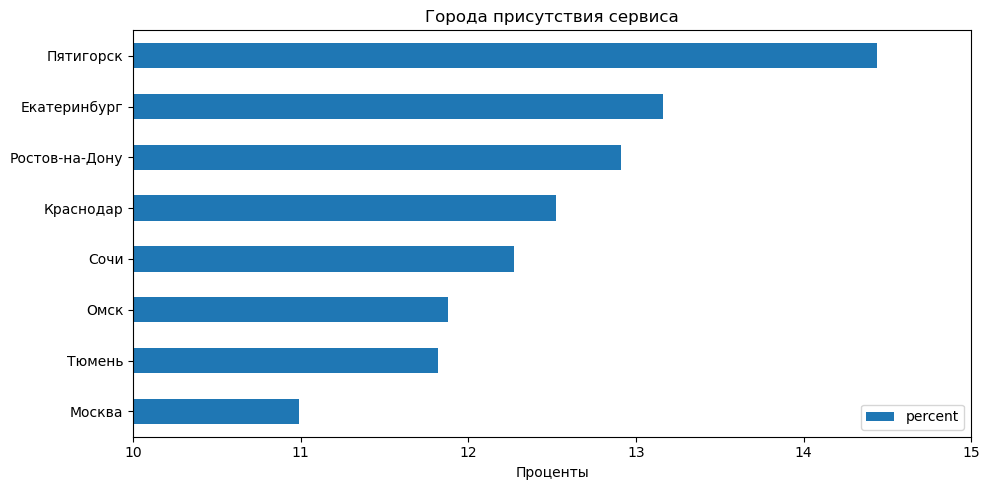

In [57]:
cities_count['percent'].plot(kind='barh',figsize=(10,5))
plt.xlim(10,15)
plt.xlabel('%')
plt.title('Города присутствия сервиса')
plt.legend(loc='best')
plt.yticks(np.arange(len(cities_count)), cities_count['city'])
plt.xlabel('Проценты')
plt.tight_layout()
plt.show();

Сервис проката работает в восьми городах России: Пятигорске, Екатеринбурге, Ростове-на-Дону, Краснодаре, Сочи, Омске, Тюмени и Москве. Больше всего пользователей сервиса в Пятигорске, Екатеринбурге и Ростове-на-Дону, меньше всего в Москве, Тюмени и Омске. Возможно, это связано с большой конкуренцией в последних городах.

In [59]:
def get_percent(data, column):
    data['percent'] = data[column]/data.shape[0]
    

Найдем, сколько в общем пользователей пользуются подпиской, а сколько нет.

In [61]:
users_type = users.groupby('subscription_type')['user_id'].agg('count').reset_index()
users_type.columns = ['subscription_type', 'users_count']
users_type['percent'] = round(users_type['users_count'] * 100 /(users_type['users_count'].sum()),2)
users_type

,subscription_type,users_count,percent
0,free,846,54.06
1,ultra,719,45.94


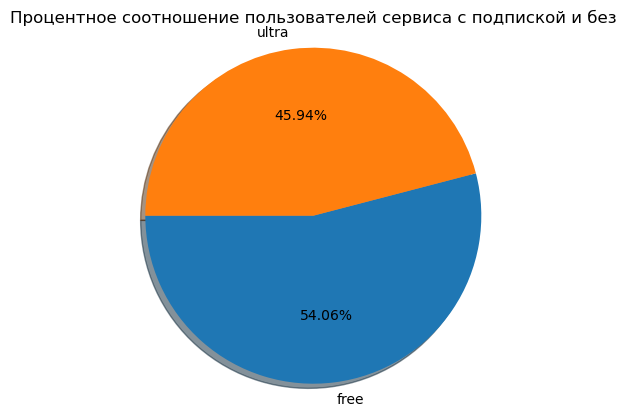

In [62]:
plt.title('Процентное соотношение пользователей сервиса с подпиской и без')
plt.pie(users_type['percent'],labels=users_type['subscription_type'],shadow=True,autopct='%1.2f%%',startangle=180)
plt.axis('equal')
plt.show()

Видим, что большая часть пользователей не пользуются подпиской. Посмотрим на это соотношение в разрезе по городам.

In [64]:
users_subs = users.pivot_table(index='city',columns='subscription_type',values ='user_id',aggfunc='count')
#users_subs.reset_index(inplace=True)
users_subs['free_%'] = round(users_subs['free']*100/(users_subs['free']+users_subs['ultra']),2)
users_subs['ultra_%'] = round(users_subs['ultra']*100/(users_subs['free']+users_subs['ultra']),2)
users_subs

subscription_type,free,ultra,free_%,ultra_%
city,,,,
Екатеринбург,114,92,55.34,44.66
Краснодар,112,84,57.14,42.86
Москва,84,88,48.84,51.16
Омск,92,94,49.46,50.54
Пятигорск,128,98,56.64,43.36
Ростов-на-Дону,112,90,55.45,44.55
Сочи,104,88,54.17,45.83
Тюмень,100,85,54.05,45.95


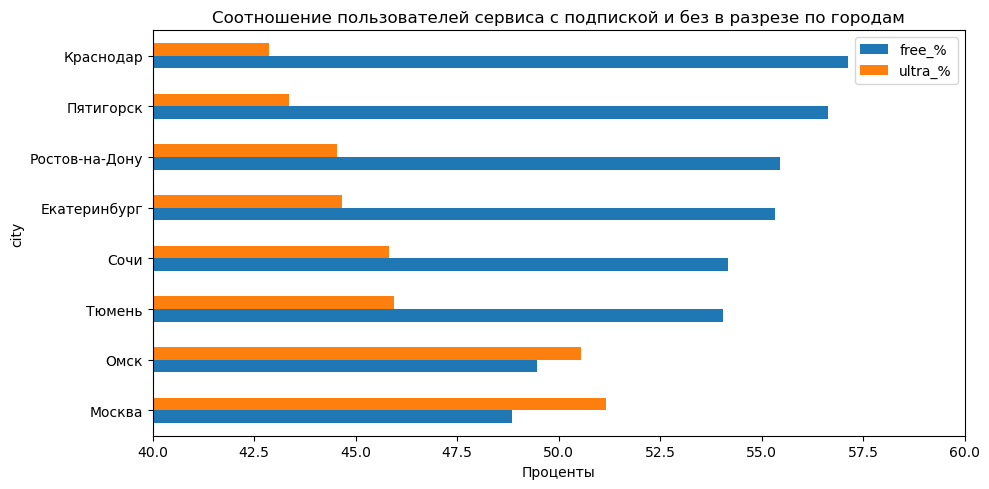

In [65]:
users_subs = users_subs.sort_values(by='free_%', ascending=True)
users_subs[['free_%','ultra_%']].plot(kind='barh',figsize=(10,5))
plt.xlim(40,60)
plt.xlabel('%')
plt.title('Соотношение пользователей сервиса с подпиской и без в разрезе по городам')
plt.legend(loc='best')
plt.yticks(np.arange(len(users_subs)), users_subs.index)
plt.xlabel('Проценты')
plt.tight_layout()
plt.show();

Как видим, в большинстве городов люди предпочитают пользоваться сервисом без подписки, только в Омске и Москве доля пользователей с подпиской выше.

Посмотрим, какого возраста пользователи сервиса.

Для начала, посмотрим какой возраст у пользователей.

In [68]:
users['age'].unique()

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43], dtype=int64)

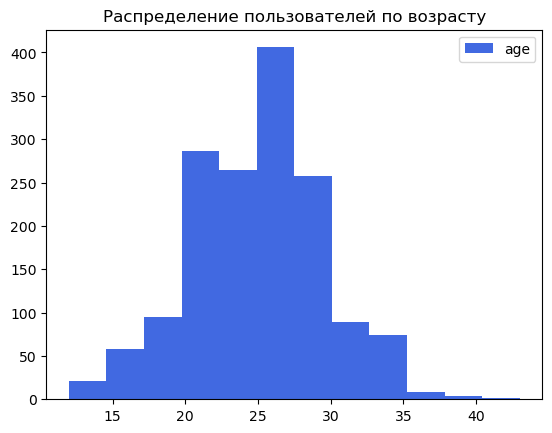

In [69]:
plt.hist(users['age'], bins=12, color='royalblue', label='age')

plt.title('Распределение пользователей по возрасту')
plt.legend();

In [70]:
users['age'].describe()

count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Пользователи сервиса в основном это люди в возрасте 20-30 лет, хотя встречаются пользователи младше 15 лет и старше 40.

Проверим, как распределены пользователи сервиса по возрасту в разных городах.

In [72]:
cities = users['city'].unique()
cities    

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

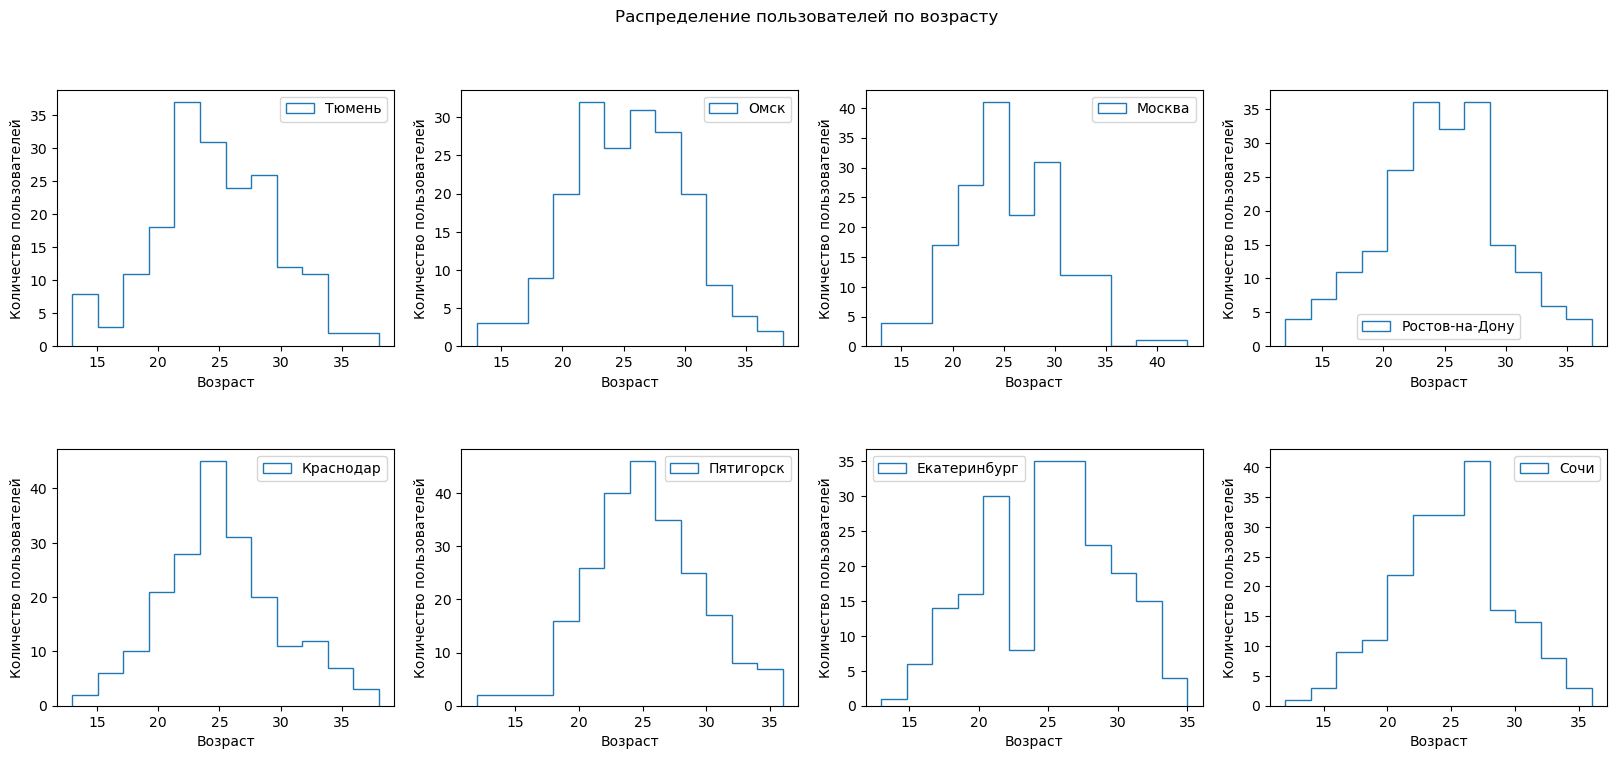

In [73]:
i = 1
plt.figure(figsize=[20, 8])
plt.suptitle('Распределение пользователей по возрасту')
plt.subplots_adjust(hspace=0.4)
for city in cities:
    plt.subplot(2,4,i)
    plt.hist(users[users['city']==city]['age'], bins=12, histtype='step', label=city)
    #plt.title('Распределение пользователей по возрасту')
    plt.legend();
   # plt.show();
    i+=1
    plt.xlabel('Возраст');
    plt.ylabel('Количество пользователей');

Во всех городах присутствия сервиса есть пользователи младше 15 лет, пользователи старше 40 лет есть только в Москве. В Екатеринбурге основными пользователями являются люди в возрасте 20-22 и 24-28 лет.

Сравним пользователей с подпиской и без по возрасту.

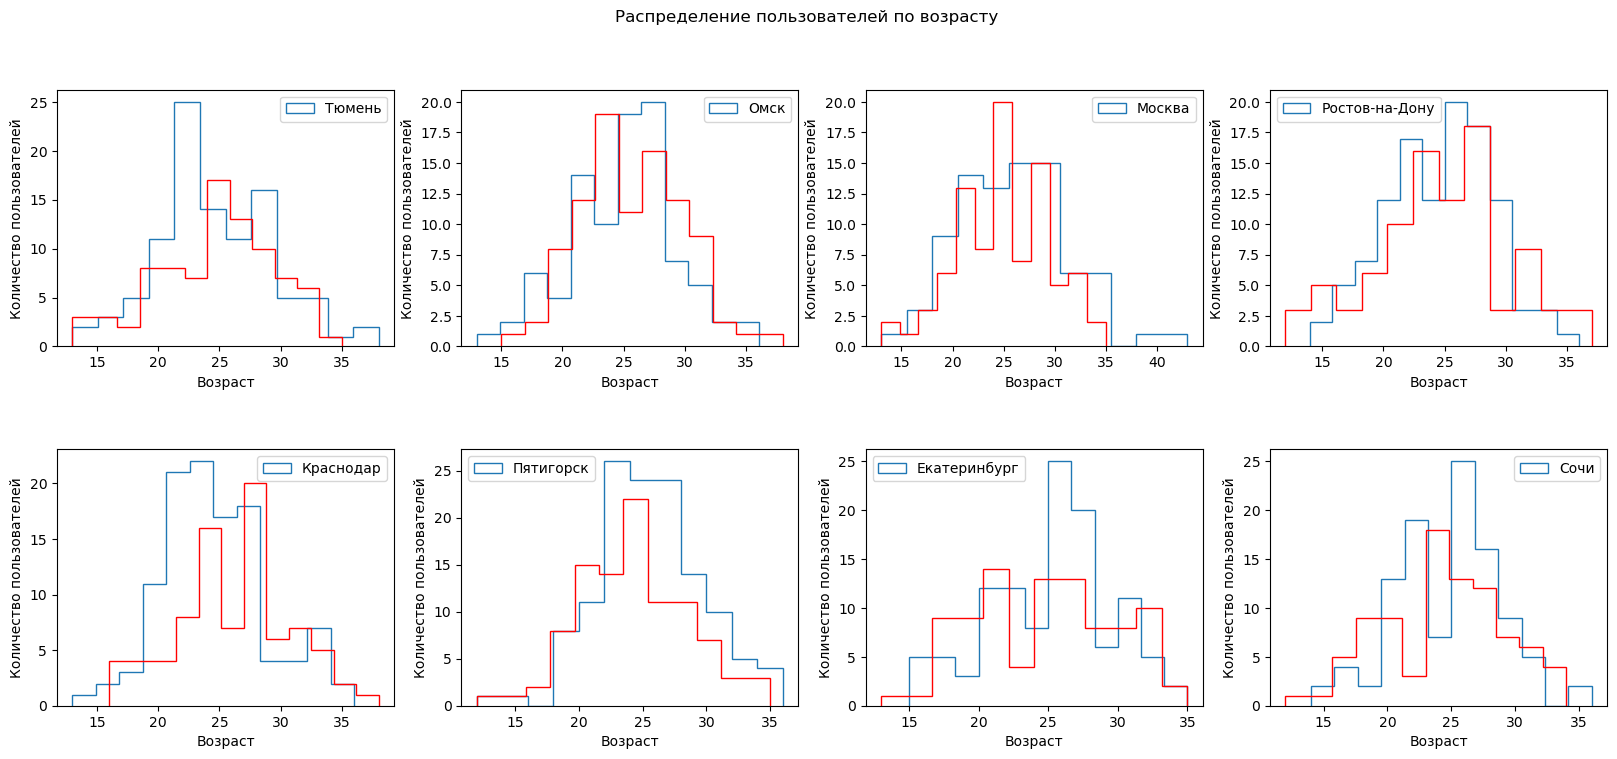

In [75]:
i = 1
plt.figure(figsize=[20, 8])
plt.suptitle('Распределение пользователей по возрасту')
plt.subplots_adjust(hspace=0.4)
for city in cities:
    plt.subplot(2,4,i)
    plt.hist(users.loc[(users['city']==city) & (users['subscription_type']=='free')]['age'], bins=12, histtype='step', label=city)
    plt.hist(users.loc[(users['city']==city) & (users['subscription_type']=='ultra')]['age'], bins=12, histtype='step', color='red')
    #plt.title('Распределение пользователей по возрасту')
    plt.legend();
   # plt.show();
    i+=1
    plt.xlabel('Возраст');
    plt.ylabel('Количество пользователей');

Во всех городах, кроме Омска и Краснодара пользователи младше 15 лет имеют подписку, в Москве и Омске больше всего имеют подписку пользователи в возрасте 24-25 лет. Без подписки сервисом пользуются разрые группы пользователей, в Тюмени, например, это возраст примерно 22-24 лет, а в Екатеринбурге и Сочи в возрасте 25-28 лет, в Краснодаре и Пятигорске от 20 до 28 лет. Пользователи старше 30 лет в большинстве городов предпочитают оплачивать подписку.

Теперь посмотрим какой дальности поездки совершают пользователи.

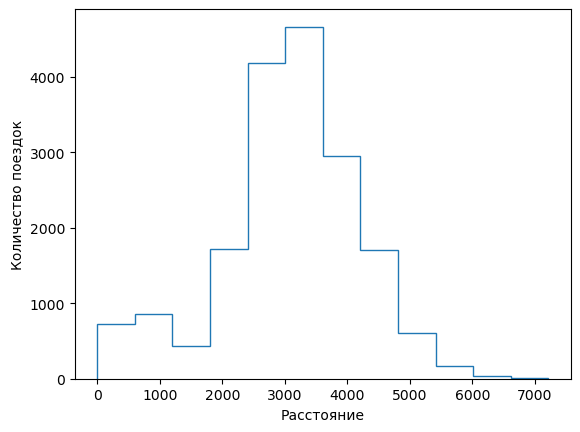

In [78]:
plt.hist(rides['distance'], bins=12, histtype='step');
plt.xlabel('Расстояние');
plt.ylabel('Количество поездок');

В основном поездки были на расстояние 3000-3300 метров. Однако, есть поездки и на расстояние превышающие 6 км.

In [80]:
rides.duration.unique()

array([25.59976897, 15.81687145,  6.23211346, ..., 18.43505138,
       16.6743622 , 15.89391697])

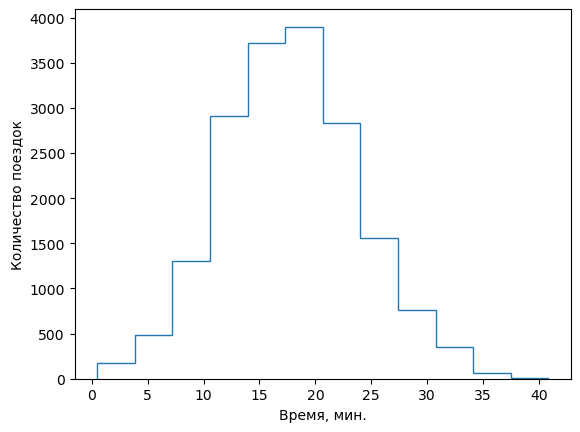

In [81]:
plt.hist(rides['duration'], bins=12, histtype='step');
plt.xlabel('Время, мин.');
plt.ylabel('Количество поездок');

Большая часть поездок длилась 15-20 минут, но есть поездки длительностью больше 35 минут.

## Объединение данных

Объединим наши данные в один датасет.

In [85]:
print(f'У нас есть данные о {users.shape[0]} пользователях')

У нас есть данные о 1565 пользователях


In [86]:
print(f'У нас есть данные о {rides.shape[0]} поездках')

У нас есть данные о 18068 поездках


In [87]:
print(f'У нас есть данные о {subscriptions.shape[0]} вариантах использования сервиса')

У нас есть данные о 2 вариантах использования сервиса


In [88]:
data = users.merge(rides, on='user_id', how='left')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,2021-01,10.335841
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,2021-01,9.929620
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,2021-04,7.260713
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,2021-08,8.734644
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,2021-08,9.202888


In [89]:
data = data.merge(subscriptions, on='subscription_type',how='left')
print(f'Мы получили датасет размера {rides.shape[0]} строк')
data.tail()

Мы получили датасет размера 18068 строк


,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee
18383,1045,Артемий,28,Ростов-на-Дону,free,2071.208099,11.970899,2021-09-09,2021-09,10.381215,8,50,0
18384,1045,Артемий,28,Ростов-на-Дону,free,2276.403184,7.253238,2021-10-14,2021-10,18.830788,8,50,0
18385,1045,Артемий,28,Ростов-на-Дону,free,3122.193371,18.610967,2021-11-05,2021-11,10.065657,8,50,0
18386,1045,Артемий,28,Ростов-на-Дону,free,3251.971296,15.504549,2021-11-11,2021-11,12.584582,8,50,0
18387,1045,Артемий,28,Ростов-на-Дону,free,3651.976111,19.532556,2021-12-15,2021-12,11.218120,8,50,0


Проверим, что в объединеннном датасете нет пропусков

In [91]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
speed                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Разделим получившийся датасет на два по типу подписки: с подпиской и без.

In [93]:
data_free = data[data['subscription_type']=='free']
data_free.sample(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee
11493,1064,Милана,21,Москва,free,4216.853354,15.433707,2021-11-29,2021-11,16.393418,8,50,0
14930,1312,Регина,21,Краснодар,free,2538.958533,11.093500,2021-05-29,2021-05,13.732141,8,50,0
11057,1032,Галина,27,Екатеринбург,free,1795.642178,10.591284,2021-04-30,2021-04,10.172376,8,50,0
17858,1521,Галина,26,Пятигорск,free,3368.123418,23.104370,2021-04-21,2021-04,8.746718,8,50,0
7267,753,Кира,26,Пятигорск,free,3615.321298,11.343049,2021-09-03,2021-09,19.123542,8,50,0


In [94]:
data_free.shape[0]

11716

In [95]:
data_subs = data[data['subscription_type']=='ultra']
data_subs.sample(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee
664,73,Лев,23,Пятигорск,ultra,2474.930512,10.711378,2021-09-02,2021-09,13.863373,6,0,199
5238,562,Олеся,23,Омск,ultra,3154.471885,20.886180,2021-12-05,2021-12,9.061892,6,0,199
1096,117,Елисей,20,Ростов-на-Дону,ultra,3074.756432,14.224269,2021-03-04,2021-03,12.969762,6,0,199
1379,149,Лиана,18,Екатеринбург,ultra,3052.567235,17.963219,2021-01-04,2021-01,10.196059,6,0,199
3910,421,Ульяна,32,Омск,ultra,3400.628515,15.871205,2021-09-24,2021-09,12.855843,6,0,199


In [96]:
data_subs.shape[0]

6672

Теперь мы можем оценить дальность поездки по городам и по типу подписки пользователя.

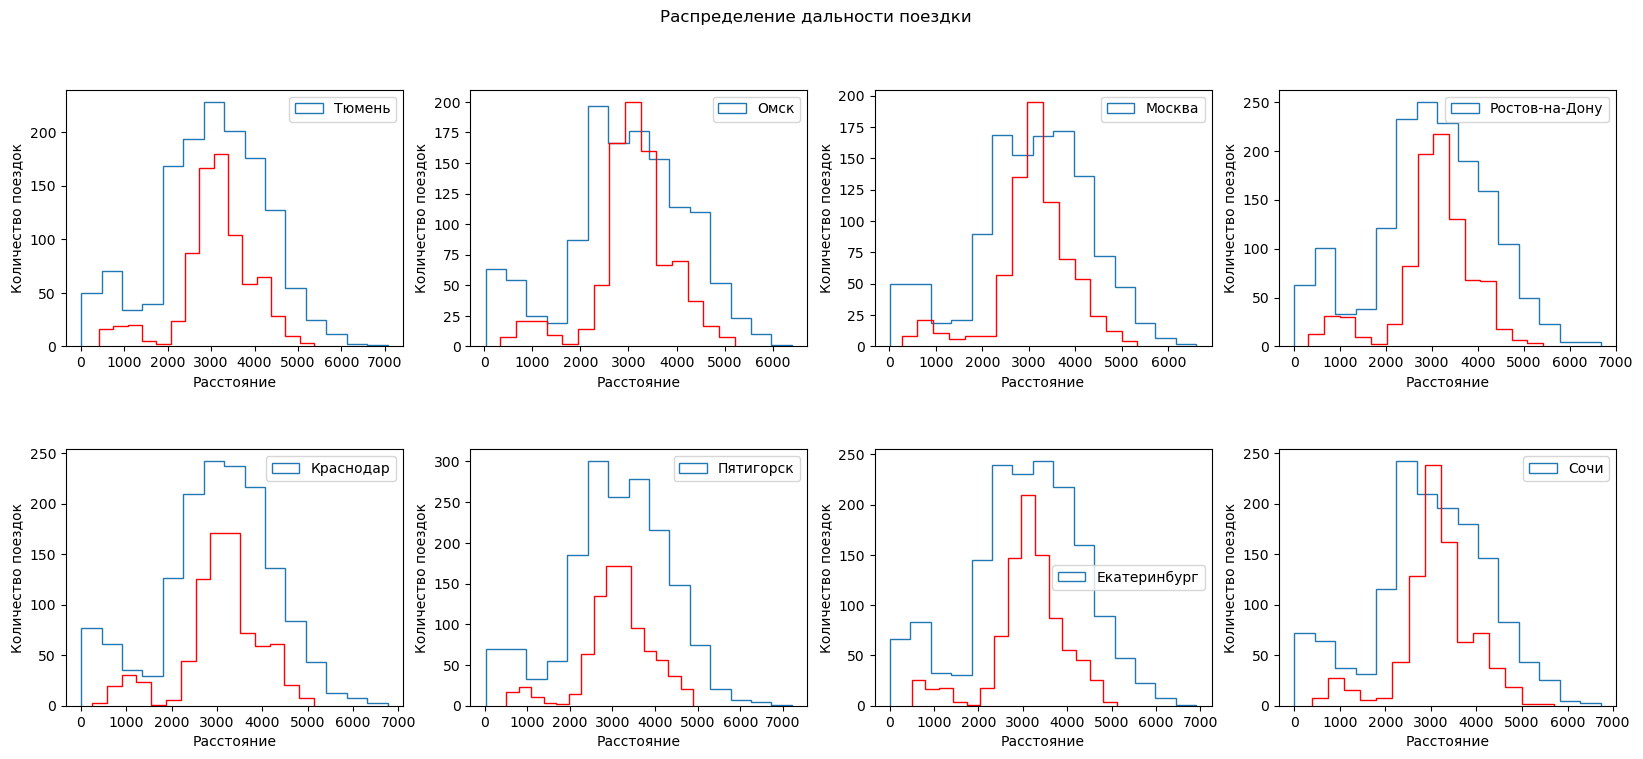

In [98]:
i = 1
plt.figure(figsize=[20, 8])
plt.suptitle('Распределение дальности поездки')
plt.subplots_adjust(hspace=0.4)
for city in cities:
    plt.subplot(2,4,i)
    plt.hist(data_free[data_free['city']==city].distance, bins=15, histtype='step', label=city)
    plt.hist(data_subs[data_subs['city']==city].distance, bins=15, histtype='step', color='red')
    plt.legend() 
    i+=1
    plt.xlabel('Расстояние')
    plt.ylabel('Количество поездок');

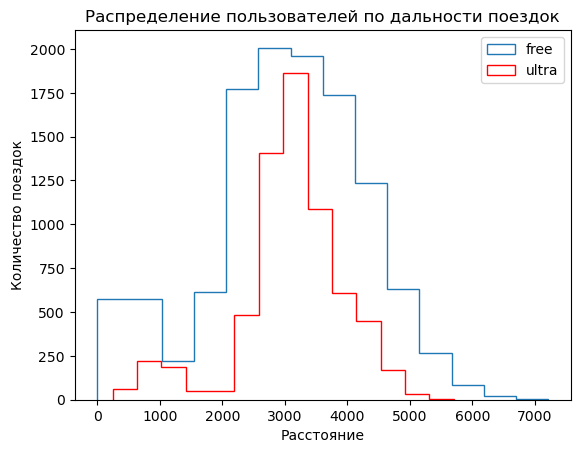

In [99]:
plt.hist(data_free.distance, bins=14, histtype='step', label='free')
plt.hist(data_subs.distance, bins=14, histtype='step', color='red', label='ultra')
plt.title('Распределение пользователей по дальности поездок')
plt.legend()
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок');

Мы можем сказать, что пользователи с подпиской чаще всего совершают поездки на расстояние от 3000-3500 метров, в то время как пользователи без подписки чаще всего совершали поездки дальностью 2000-4000 метров, при этом картина практически одинакова по всем городам. Дальние поездки больше 6 км совершают пользователи без подписки.

Оценим длительность поездок.

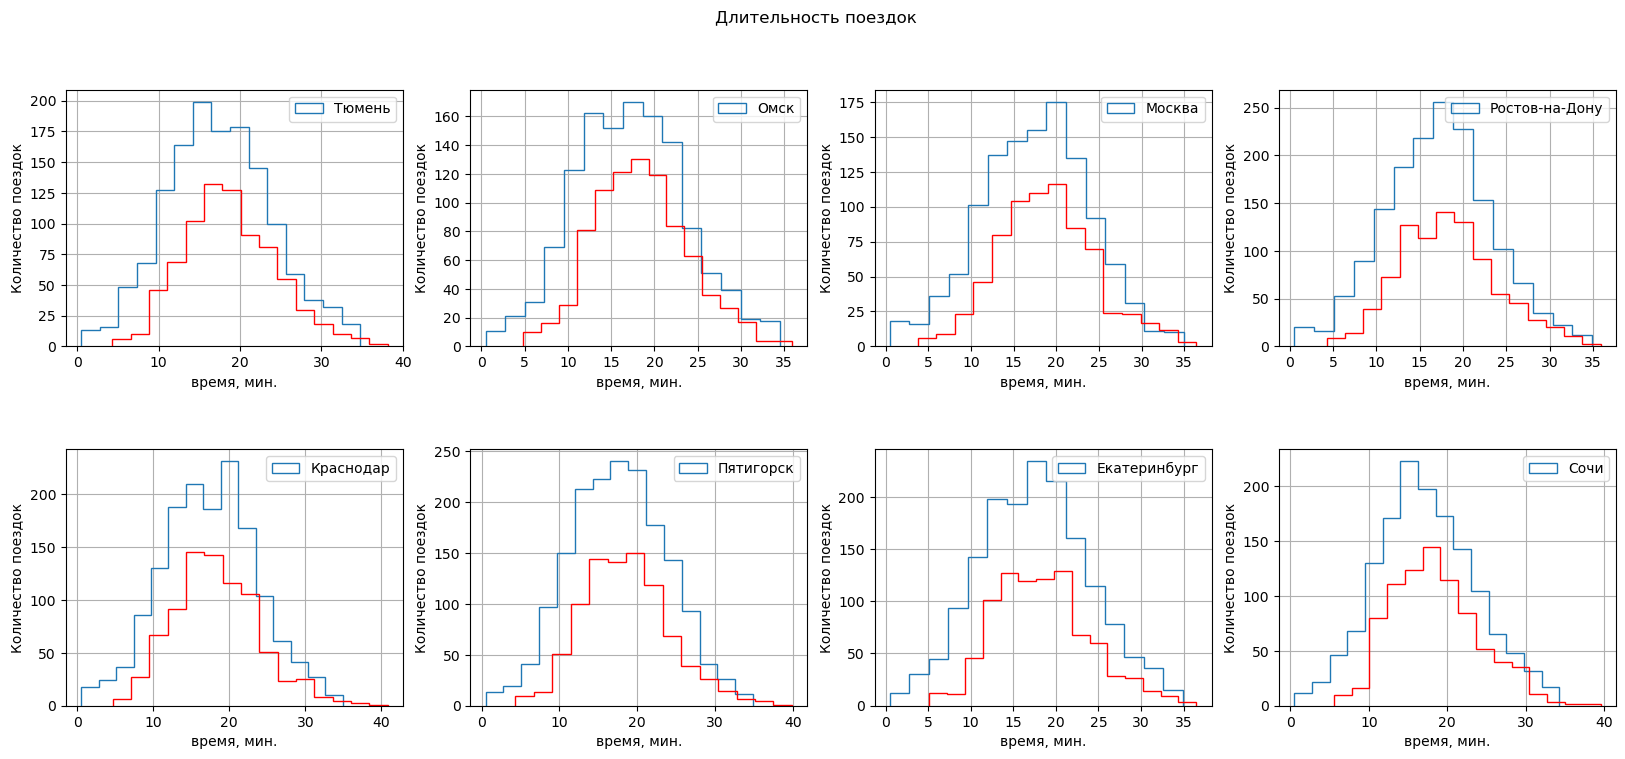

In [102]:
i = 1
plt.figure(figsize=[20, 8])
plt.suptitle('Длительность поездок')
plt.subplots_adjust(hspace=0.4)
for city in cities:
    plt.subplot(2,4,i)
    plt.grid()
    plt.hist(data_free[data_free['city']==city].duration, bins=15, histtype='step', label=city)
    plt.hist(data_subs[data_subs['city']==city].duration, bins=15, histtype='step', color='red')
    plt.legend()
    i+=1
    plt.xlabel('время, мин.')
    plt.ylabel('Количество поездок');

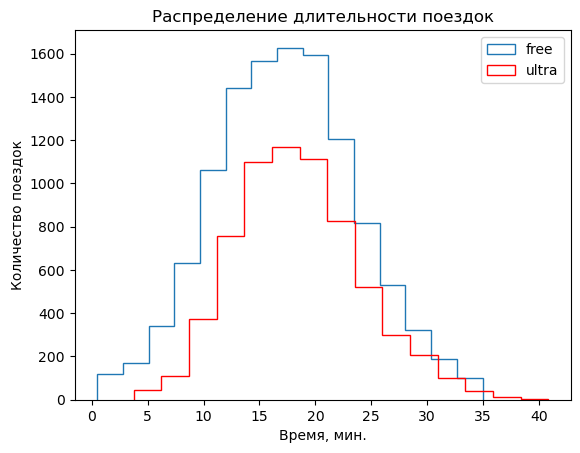

In [103]:
plt.hist(data_free.duration, bins=15, histtype='step', label='free')
plt.hist(data_subs.duration, bins=15, histtype='step', color='red', label='ultra')
plt.title('Распределение длительности поездок')
plt.legend()
plt.xlabel('Время, мин.')
plt.ylabel('Количество поездок');

Пользователи с подпиской чаще всего ездили на самокатах 15-20 минут, пользователи без подписки от 10 до 25 минут, долгие поездки больше 35 минут совершали пользователи с подпиской.

## Подсчёт выручки

Посчитаем какую выручку нам приносят пользователи ежемесячно.

Сначала округлим время каждой поездки до большего целого.

In [107]:
data['duration_round'] = np.ceil(data['duration'])
data.head(15)

,user_id,name,age,city,subscription_type,distance,duration,date,month,speed,minute_price,start_ride_price,subscription_fee,duration_round
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,2021-01,10.335841,6,0,199,26.0
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,2021-01,9.929620,6,0,199,16.0
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,2021-04,7.260713,6,0,199,7.0
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,2021-08,8.734644,6,0,199,19.0
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,2021-08,9.202888,6,0,199,27.0
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,2021-10,9.985109,6,0,199,17.0
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,2021-10,12.214811,6,0,199,15.0
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,2021-11,7.376547,6,0,199,24.0
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,2021-11,13.437490,6,0,199,16.0
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,2021-11,2.986424,6,0,199,16.0


In [174]:
data_agg = data.pivot_table(index=['user_id','month'], aggfunc={'distance':'sum','duration_round':'sum','user_id':'count','subscription_type':'first'})
data_agg.columns = ['total_distance', 'total_duration','subscription_type','trip_count']
data_agg = data_agg.reset_index()

Далее, для каждого пользователя помесячно посчитаем общую дальность и длительность поездок, а также их количество

In [177]:
data_agg.head(10)

,user_id,month,total_distance,total_duration,subscription_type,trip_count
0,1,2021-01,7027.511294,42.0,ultra,2
1,1,2021-04,754.159807,7.0,ultra,1
2,1,2021-08,6723.470560,46.0,ultra,2
3,1,2021-10,5809.911100,32.0,ultra,2
4,1,2021-11,7003.499363,56.0,ultra,3
5,1,2021-12,6751.629942,28.0,ultra,2
6,2,2021-03,10187.723006,63.0,ultra,3
7,2,2021-04,6164.381824,40.0,ultra,2
8,2,2021-06,3255.338202,14.0,ultra,1
9,2,2021-07,6780.722964,48.0,ultra,2


In [111]:
data_set = data.pivot_table(index=['user_id','month'], aggfunc={'minute_price':'first','subscription_fee':'first','start_ride_price':'first'})
data_set = data_set.reset_index()
data_set.head(10)

,user_id,month,minute_price,start_ride_price,subscription_fee
0,1,2021-01,6,0,199
1,1,2021-04,6,0,199
2,1,2021-08,6,0,199
3,1,2021-10,6,0,199
4,1,2021-11,6,0,199
5,1,2021-12,6,0,199
6,2,2021-03,6,0,199
7,2,2021-04,6,0,199
8,2,2021-06,6,0,199
9,2,2021-07,6,0,199


Добавим столбец с ежемесячной выручкой

In [183]:
data_agg['month_revenue'] = data_agg.trip_count * data_set.start_ride_price + data_agg.total_duration * data_set.minute_price + data_set.subscription_fee

In [185]:
data_agg.head(10)

,user_id,month,total_distance,total_duration,subscription_type,trip_count,month_revenue
0,1,2021-01,7027.511294,42.0,ultra,2,451.0
1,1,2021-04,754.159807,7.0,ultra,1,241.0
2,1,2021-08,6723.470560,46.0,ultra,2,475.0
3,1,2021-10,5809.911100,32.0,ultra,2,391.0
4,1,2021-11,7003.499363,56.0,ultra,3,535.0
5,1,2021-12,6751.629942,28.0,ultra,2,367.0
6,2,2021-03,10187.723006,63.0,ultra,3,577.0
7,2,2021-04,6164.381824,40.0,ultra,2,439.0
8,2,2021-06,3255.338202,14.0,ultra,1,283.0
9,2,2021-07,6780.722964,48.0,ultra,2,487.0


Посмотрим какие результаты мы получили

In [188]:
data_agg.shape[0]

11331

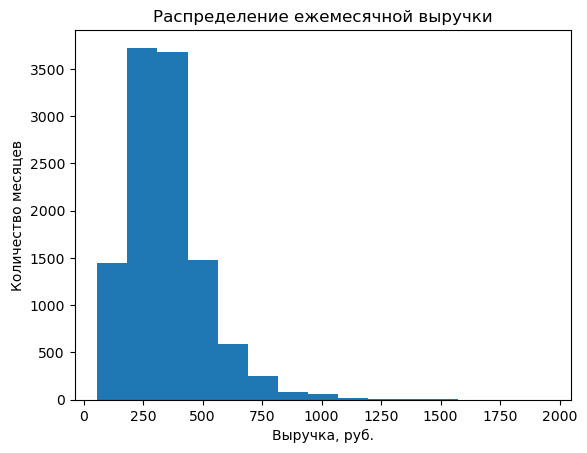

In [190]:
plt.hist(data_agg['month_revenue'], bins=15)
plt.title('Распределение ежемесячной выручки')
plt.xlabel('Выручка, руб.')
plt.ylabel('Количество месяцев');

In [192]:
data_agg['month_revenue'].describe()

count    11331.000000
mean       346.550084
std        160.289903
min         58.000000
25%        234.000000
50%        319.000000
75%        421.000000
max       1952.000000
Name: month_revenue, dtype: float64

Видим, что в среднем один пользователь в месяц приносит от 250 до 350 рублей.

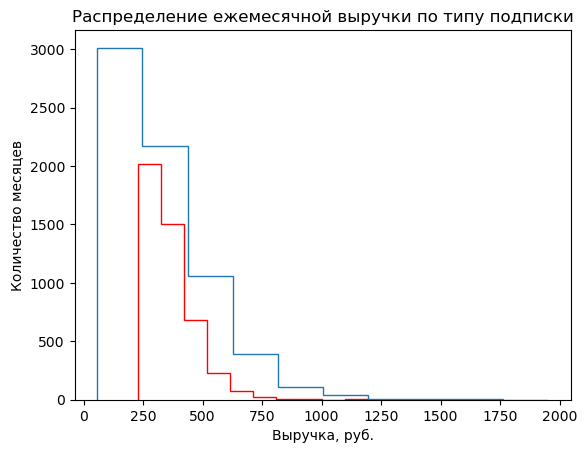

In [195]:
plt.hist(data_agg.query('subscription_type=="ultra"')['month_revenue'], bins=10, histtype='step', color='red');
plt.hist(data_agg.query('subscription_type=="free"')['month_revenue'], bins=10, histtype='step');
plt.title('Распределение ежемесячной выручки по типу подписки')
# plt.show();
plt.xlabel('Выручка, руб.');
plt.ylabel('Количество месяцев');

Видим, что пользователи без подписки чаще всего платят за пользование самокатами до 250 рублей в месяц, пользователи с подпиской платят от 250 до 400 рублей (при этом почти 200 рублей составляет ежемесячная плата за подписку). 

## Проверка гипотез

Нам важно понять, тратят ли пользователи с подпиской больше времени на поездки?

Для этого посчитаем среднюю длительность поездки пользователей с подпиской и без.

In [209]:
print(f'Средняя длительность поездки пользователей без подписки:{np.mean(data_free["duration"])}')
print(f'Средняя длительность поездки пользователей с подпиской:{np.mean(data_subs["duration"])}')

Средняя длительность поездки пользователей без подписки:17.394835496775148
Средняя длительность поездки пользователей с подпиской:18.531418736230428


Видим, что средняя длительность поездки пользователей с подпиской больше. Тогда проверим гипотезу о том, что пользователи с подпиской ездят дольше, чем пользователи без подписки.

Выдвигаем две гипотезы, основную H0 и альтернативную H1.

H0: средняя длительность поездки пользователей без подписки и с подпиской равны

H1: средняя длительность поездки у пользователей с подпиской больше, чем у пользователей без подписки.

In [205]:
alpha = 0.01 # задаем уровень значимости
results = st.ttest_ind(data_subs['duration'], data_free['duration'],alternative='greater') # используем t-тест для проверки гипотезы 
# о равенстве средних
print('p-значение:', results.pvalue) # найдем p-значение
if results.pvalue < alpha:
    print('Отвергаем гипотезу H0')
else:
     print('Отвергнуть гипотезу H0 не получилось')   

p-значение: 1.6261032773544602e-34
Отвергаем гипотезу H0


Таким образом, мы отвергаем гипотезу о равенстве средних длительностей в пользу альтернативной, гласящей о том, что пользователи с подпиской ездят дольше.

Оптимальное с точки зрения износа самоката расстояние одной поезки составляет 3130 метров. Проверим, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

In [212]:
value=3130 # задаем значение, с которым будем сравнивать среднюю дальность поездки
print(f'Средняя дальность поездки пользователей с подпиской:{np.mean(data_subs["distance"])}')
alpha = 0.05 # задаем уровень значимости

Средняя дальность поездки пользователей с подпиской:3115.4349626434296


Средняя дальность поездки пользователей с подпиской не превышает заданное значение, поэтому выдвинем для проверки две гипотезы:

H0: средняя дальность поздки пользователей с подпиской равна 3130 метрам

H1: подписчики в среднем проезжают расстояние больше оптимального

In [215]:
results = st.ttest_1samp(data_subs["distance"], value, alternative='greater') # используем t-тест для проверки гипотезы о равенстве
# средней генеральной совокупности заданному значению
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем гипотезу H0')
else:
     print('Отвергнуть гипотезу H0 не получилось') 

p-значение: 0.9224525735507901
Отвергнуть гипотезу H0 не получилось


В результате мы не можем отвергнуть гипотезу, что средняя дальность поездки пользователей с подпиской равна 3130 метрам, а следовательно не можем сказать, что дальность меньше этого значения.

Проверим, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Для этого разделим наш датафрейм на два: данные о пользователях с подпиской и без.

In [220]:
data_agg_free = data_agg[data_agg['subscription_type']=="free"]
data_agg_ultra = data_agg[data_agg['subscription_type']=="ultra"]

Посчитаем среднюю выручку для каждого вида пользователей:

In [223]:
print(f'Средняя помесячная выручка пользователей без подписки:{np.mean(data_agg_free["month_revenue"])}')
print(f'Средняя длительность поездки пользователей с подпиской:{np.mean(data_agg_ultra["month_revenue"])}')

Средняя помесячная выручка пользователей без подписки:332.89438070020594
Средняя длительность поездки пользователей с подпиской:367.0291197882197


Выдвигаем две гипотезы:

H0: средняя помесячная выручка от пользователей без подписки и с подпиской равны

H1: средняя помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки

In [226]:
alpha = 0.01 # задаем уровень значимости
results = st.ttest_ind(data_agg_ultra['month_revenue'], data_agg_free['month_revenue'],alternative='greater') # используем t-тест
# для проверки гипотезы о равенстве двух средних значений
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем гипотезу H0')
else:
     print('Отвергнуть гипотезу H0 не получилось')   

p-значение: 4.227438894541132e-29
Отвергаем гипотезу H0


Таким образом, мы отвергаем гипотезу о том, что в среднем пользователи с подпиской и без приносят одинаковую ежемесячную выручку, в пользу гипотезы, что пользователи с подпиской платят больше.

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки такой гипотезы на бы понадобился тест scipy.stats.ttest_rel(array1, array2), где array1 - данные о количестве обращений до обновления, а array2 - данные о количестве обращений после обновления.

Нам надо будет проверить левостороннюю гипотезу.
Выдвинем следующие гипотезы:

H0: количество обращений в техподдержку до обновления и после него равны

H1: количество обращений в техподдержку после обновления снизилось.

## Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Мы имеем схему Бернулли с вероятностью успеха p = 0.1. Так как нам нужно, чтобы 100 пользователей продлили подписку, то начнем с n = 1000.

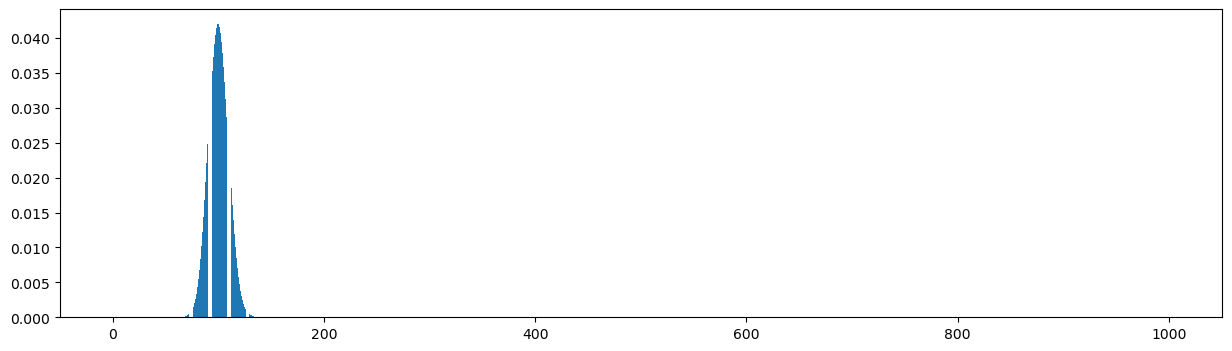

In [236]:
n = 1000
p = 0.1
distr = []
# задаем биномиальное распределение
for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1-p)**(n-k) 
    distr.append(prob)
# построим график    
plt.figure(figsize=(15,4))     
plt.bar(range(0, n + 1), distr);

Видим, что вероятность получить значения < 100 больше, чем 5%.

Для нахождения нужного количества промокодов аппроксимируем наше биномиальное распределение нормальным с параметрами mu и sigma.

In [239]:
mu = n * p
sigma = sqrt(n * p * (1 - p))

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие аппроксимации выполняется')
else:
    print('Условие аппроксимации не выполняется')


Условие аппроксимации выполняется


Построим нормальное распределение с заданными параметрами и посчитаем вероятность того, что мы получим меньше 100 пользователей, продливших подписку.

In [242]:
distr = st.norm(mu, sigma)
result = distr.cdf(100)
print(result)

0.5


Получили вероятность 50%, будем менять значение n, чтобы получить вероятность приблизительно равную 5%

In [245]:
n = 1169
mu = n * p
sigma = sqrt(n * p * (1 - p))
distr = st.norm(mu, sigma)
result = distr.cdf(100)
print(result)

0.04971489312694162


Видим, что нужно разослать минимум 1169 промокодов.

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Опять же имеем биномиальное распределение с n = 1000000 и вероятностью успеха p = 0.4

In [250]:
n = 1000000 # задаем параметры биномиального распределения
p = 0.4
mu = n * p # аппроксимируем его нормальным растпределением с параметрами mu и sigma
sigma = sqrt(n * p * (1 - p))
# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие аппроксимации выполняется')
else:
    print('Условие аппроксимации не выполняется')


Условие аппроксимации выполняется


In [252]:
distr = st.norm(mu, sigma) # задаем нормальное распределение
result = distr.cdf(399500) # считаем искомую вероятность
print(result)

0.15371708296369768


Вероятность того, что уведомление откроют 399,5 тыс.пользователей, равна 15,4%

## Выводы

Мы имеем данные о 1565 пользователях. О пользователях нам известно его user_id в системе, имя пользователя, возраст, город, в котором находится пользователь и тип подписки; данные о 18068 поездках, которые совершили наши пользователи. Мы знаем user_id пользователя, совершившего поездку, расстояние, которое проехал пользователь, время, которое было затрачено на поездку и дата поездки. Данные о варианте использования сервиса содержат лишь две строки, что подтвеждает вводную информацию, что можно использовать сервис только с подпиской или без. Мы получили данные о типе подписки, стоимости минуты, стоимости начала поезки и ежемесяной платы для каждого варианта пользования сервисом.

Нам предоставлены данные о поездках, совершенным в период с 1 января по 30 декабря 2021 года.

мы создали столбец `speed`, в котором указывается скорость движения самоката. В данных есть 117 поездок с очень низкой скоростью передвижения, скорее всего, пользователь не сразу смог разобраться в управлении, но прокат приносит прибыль за время проката, поэтому такие поездки оставим в наших данных.

Как правило скорость арендных самокатов ограничивают 25 км/ч,  у нас есть 95 поездок, где скорость аномально высокая и все они длились не больше минуты, но при этом указывается очень большое расстояние. Видимо, здесь произошел сбой. 

В данных о пользователях мы нашли 31 дубликат, которые удалили.

Сервис проката работает в восьми городах России: Пятигорске, Екатеринбурге, Ростове-на-Дону, Краснодаре, Сочи, Омске, Тюмени и Москве. Больше всего пользователей сервиса в Пятигорске, Екатеринбурге и Ростове-на-Дону, меньше всего в Москве, Тюмени и Омске. Возможно, это связано с большой конкуренцией в последних городах. 

  В среднем 54% пользователей не пользуются подпиской, в большинстве городов люди предпочитают пользоваться сервисом без подписки, только в Омске и Москве доля пользователей с подпиской выше.
  
  Пользователи сервиса в основном это люди в возрасте 20-30 лет, хотя встречаются пользователи младше 15 лет и старше 40. Во всех городах присутствия сервиса есть пользователи младше 15 лет, пользователи старше 40 лет есть только в Москве. В Екатеринбурге основными пользователями являются люди в возрасте 20-22 и 24-28 лет. Во всех городах, кроме Омска и Краснодара пользователи младше 15 лет имеют подписку, в Москве и Омске больше всего имеют подписку пользователи в возрасте 24-25 лет. Без подписки сервисом пользуются разрые группы пользователей, в Тюмени, например, это возраст примерно 22-24 лет, а в Екатеринбурге и Сочи в возрасте 25-28 лет, в Краснодаре и Пятигорске от 20 до 28 лет. Пользователи старше 30 лет в большинстве городов предпочитают оплачивать подписку.
  
  В основном поездки были на расстояние 3000-3300 метров. Однако, есть поездки и на расстояние превышающие 6 км. Мы можем сказать, что пользователи с подпиской чаще всего совершают поездки на расстояние от 3000-3500 метров, в то время как пользователи без подписки чаще всего совершали поездки дальностью 2000-4000 метров, при этом картина практически одинакова по всем городам. Дальние поездки больше 6 км совершают пользователи без подписки.
  
  Большая часть поездок длилась 15-20 минут, но есть поездки длительностью больше 35 минут. Пользователи с подпиской чаще всего ездили на самокатах 15-20 минут, пользователи без подписки от 10 до 25 минут, долгие поездки больше 35 минут совершали пользователи с подпиской.
  
  В среднем один пользователь в месяц приносит от 250 до 350 рублей. Пользователи без подписки чаще всего платят за пользование самокатами до 250 рублей в месяц, пользователи с подпиской платят от 250 до 400 рублей (при этом почти 200 рублей составляет ежемесячная плата за подписку). Больше выручки приносят пользователи без подписки.
  
  Средняя длительность поездки пользователей с подпиской больше. Проверили гипотезу о том, что пользователи с подпиской ездят дольше, чем пользователи без подписки. мы отвергли гипотезу о равенстве средних длительностей в пользу альтернативной, гласящей о том, что пользователи с подпиской ездят дольше.
  
   Оптимальное с точки зрения износа самоката расстояние одной поезки составляет 3130 метров. Проверили, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Мы не можем утверждать, что пользователи с подпиской проезжают больше оптимального.
   
   Отвергали гипотезу о том, что в среднем пользователи с подпиской и без приносят одинаковую ежемесячную выручку, в пользу гипотезы, что пользователи с подпиской платят больше.
   
   Для проведения акции с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку с вероятностью 10% необходимо разослать минимум 1169 промокодов.
   
   Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей примерно равна 15,4%.
   
   Учитывая полученные данные, можно порекомендовать уделить внимание подписке ultra. Так как пользователи с подпиской ездят в среднем дольше, и их поездки не превышают оптимального расстояния с точки зрения износа самоката, что сказывается на времени использования, а следовательно должны приносить больше выручки в долговременной перспективе, так как менять такие самокаты придется реже. На данный момент таких пользователей меньше. Чаще всего сервисом пользуются люди 20-25 лет, поэтому стоит уделить внимание этой возрастной группе.